In [ ]:
# get the latest version from pypi 
# for other installations approaches, see https://dynamo-release.readthedocs.io/en/latest/ten_minutes_to_dynamo.html#how-to-install
!pip install dynamo-release --upgrade --quiet

Let us show that velocity estimation based on slam-seq data gives more consistent and clean results. 
Note that this is irrespective of the velocity tools you will use. Original scSLAM-seq authors show that velocyto gives better results when using slam-seq data. Here I am using the same result with the recently improved scvelo package. Please come back to see the result with dynamo! 

In [1]:
import pandas as pd 
import numpy as np 

import dynamo as dyn
dyn.get_all_dependencies_version()

package,dynamo-release,tqdm,anndata,cvxopt,hdbscan,loompy,matplotlib,numba,numpy,pandas,pynndescent,python-igraph,scikit-learn,scipy,seaborn,setuptools,statsmodels,trimap,umap-learn,numdifftools,colorcet
version,0.95.0,4.48.0,0.7.4,1.2.3,0.8.26,3.0.6,3.3.0,0.48.0,1.19.1,1.1.0,0.4.8,0.8.2,0.23.1,1.5.2,0.9.0,49.3.1,0.11.1,1.0.12,0.4.3,0.9.39,2.0.2


In [2]:
# emulate ggplot2 plotting styple with white background

dyn.configuration.set_figure_params('dynamo', background='white')  

# data from Hendriks et al. 2018 

Let us first run velocity estimation based on splicing data

use wget to download the raw_data_loom_combined file and then load the loom data 

wget https://www.dropbox.com/s/a9ozcynpxudqdis/raw_data_loom_combined.loom?dl=1

here I just use data I have in my local directory

In [3]:
adata_MCMV = dyn.read_loom('/Users/xqiu/Dropbox (Personal)/dynamo/notebook_data/raw_data_loom_combined.loom')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
# add a treatment label to the adata_MCMV object
import re
batch = list()

for cell in adata_MCMV.obs.index.values:
    regex = re.compile('3LF70')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)

# add it to the adata_MCMV object
adata_MCMV.obs['virus'] = np.array(batch)

In [5]:
adata_MCMV

AnnData object with n_obs × n_vars = 1146 × 56007
    obs: 'virus'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/preprocessing/preprocess.py:1441: UserWarning: Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default color cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.
  warnings.warn('Dynamo is not able to perform cell cycle staging for you automatically. \n'
/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
estimating gamma: 100%|██████████| 1000/1000 [00:09<00:0

<Figure size 600x400 with 0 Axes>

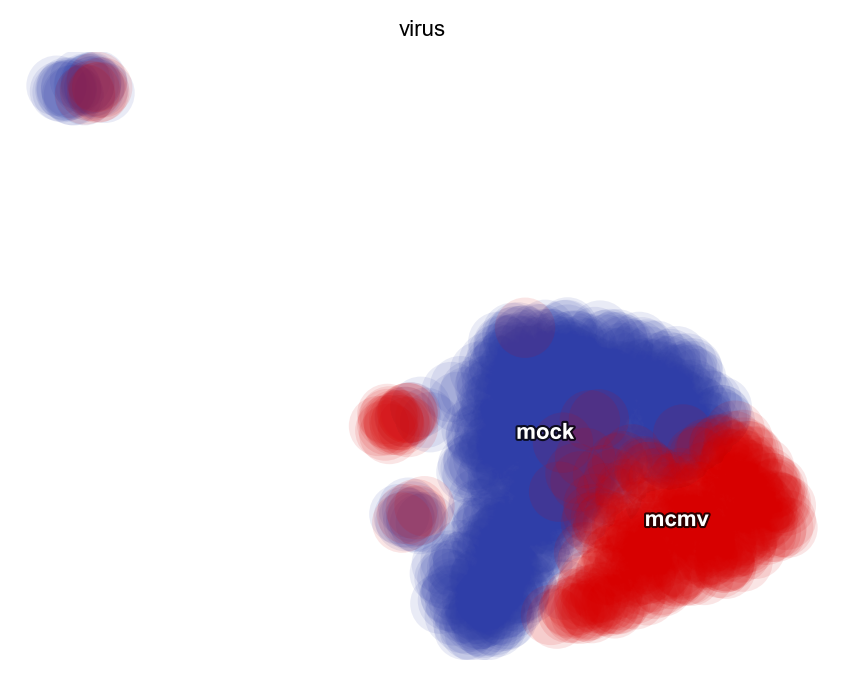

In [6]:
dyn.pp.recipe_monocle(adata_MCMV, n_top_genes=1000)
dyn.tl.dynamics(adata_MCMV, model='stochastic') 
# or dyn.tl.dynamics(adata, model='stochastic')
# or dyn.tl.dynamics(adata, model='stochastic', est_method='negbin')

dyn.tl.reduceDimension(adata_MCMV)

dyn.pl.umap(adata_MCMV, color='virus')

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 1146/1146 [00:02<00:00, 462.35it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 1146/1146 [00:00<00:00, 4117.77it/s]


<Figure size 600x400 with 0 Axes>

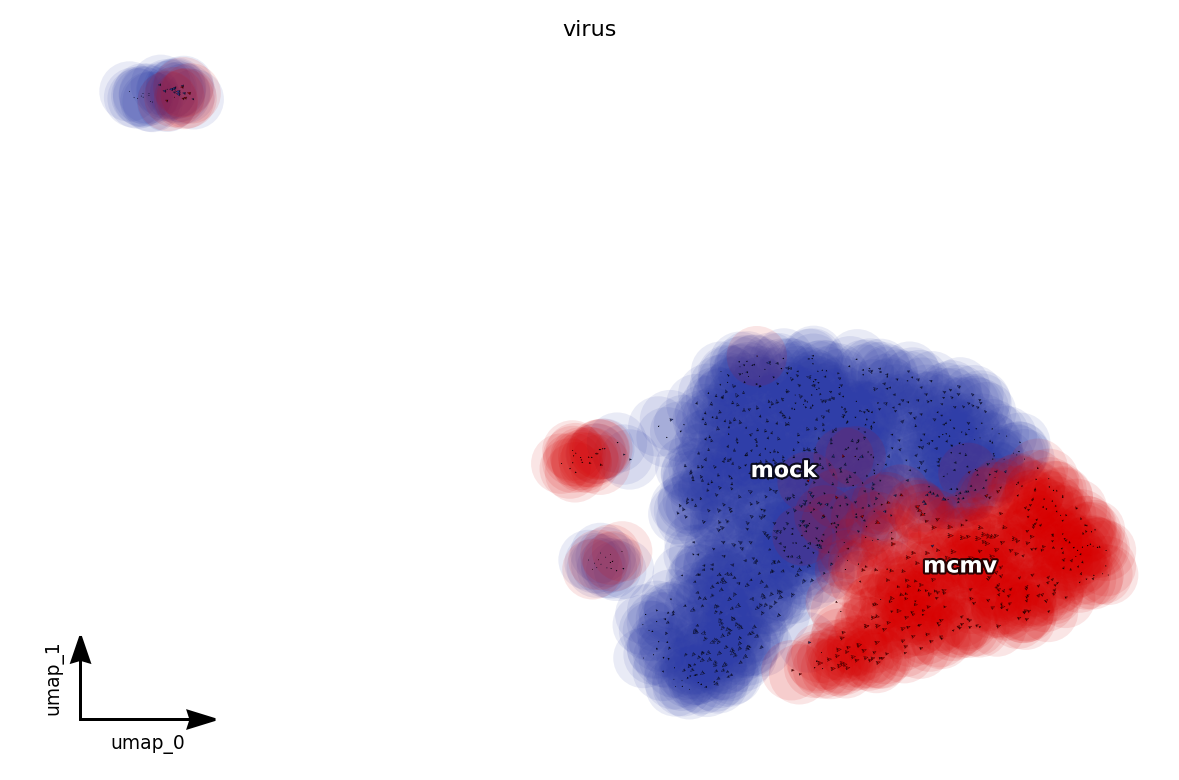

In [7]:
dyn.tl.cell_velocities(adata_MCMV)
# dyn.pl.phase_portraits(adata_MCMV, genes=['RERE', 'ENO1', 'DHRS3'], ncols=3, figsize=(3, 3))
dyn.pl.cell_wise_vectors(adata_MCMV, color=['virus'], basis='umap', quiver_scale=2, show_legend='on data') # ['GRIA3', 'LINC00982', 'AFF2']


<Figure size 600x400 with 0 Axes>

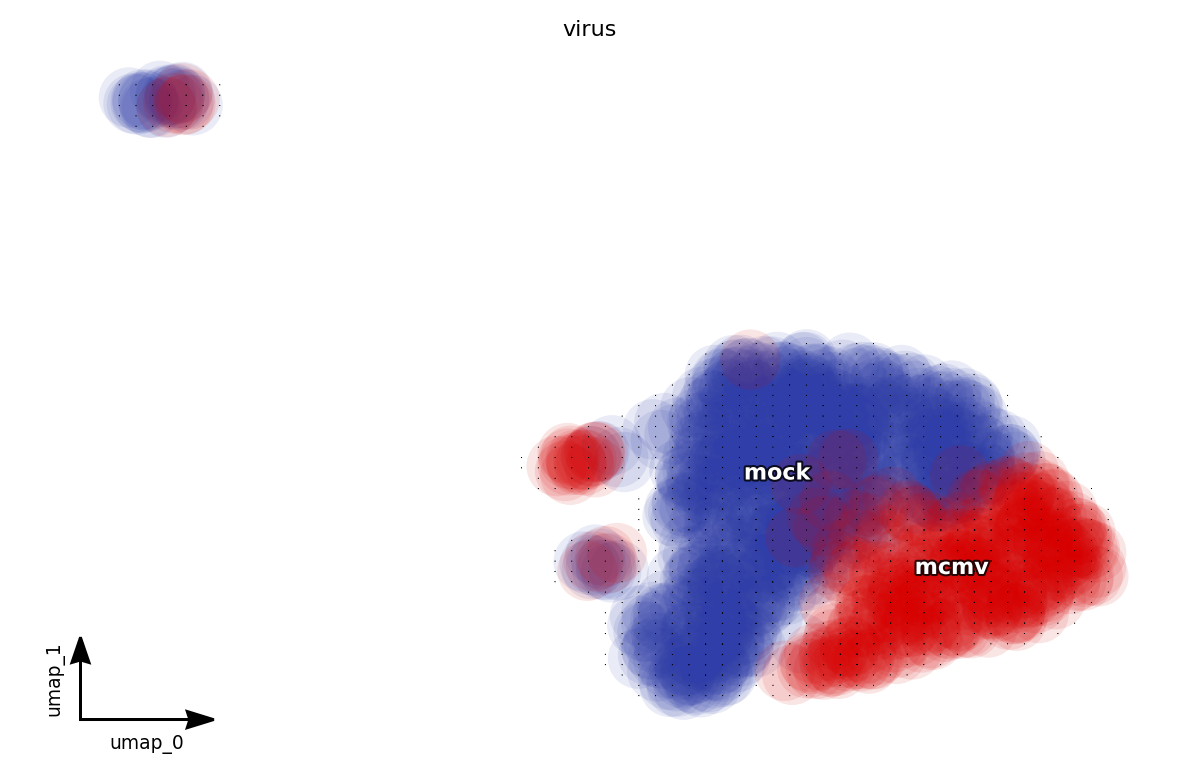

In [8]:
dyn.pl.grid_vectors(adata_MCMV, color=['virus'], basis='umap', xy_grid_nums=(60,60)) # ['GRIA3', 'LINC00982', 'AFF2']


<Figure size 600x400 with 0 Axes>

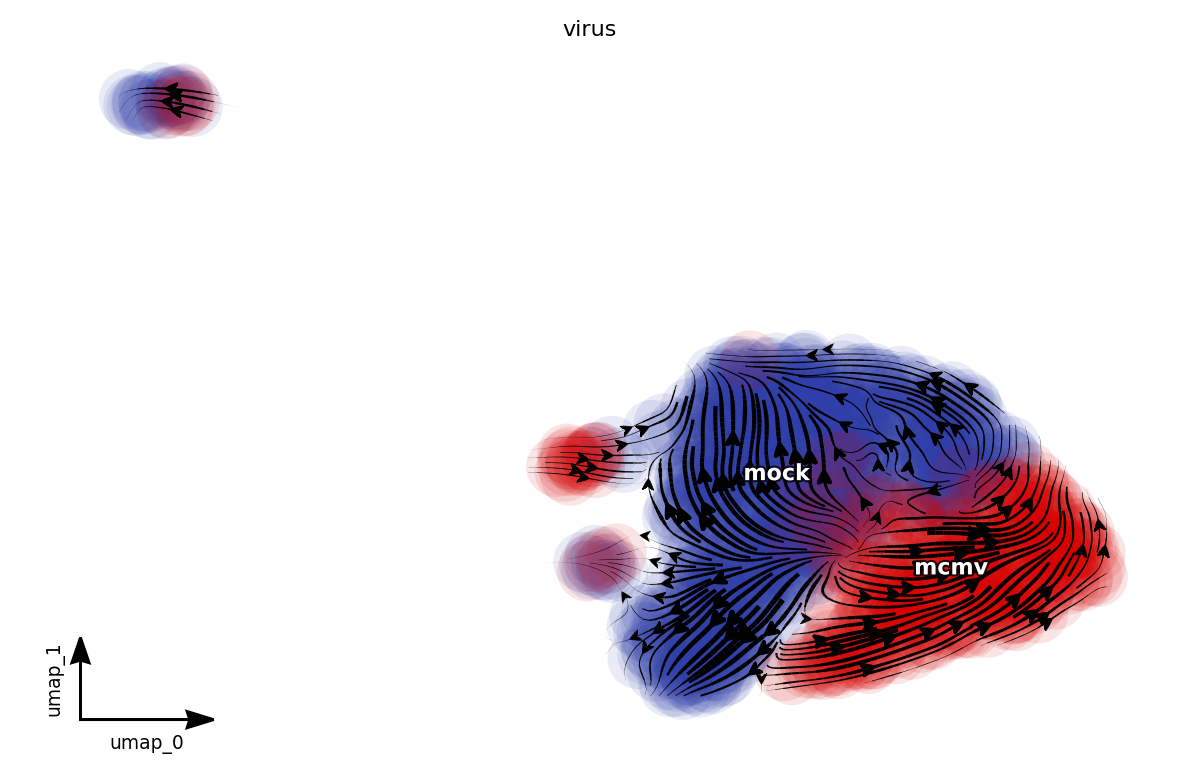

In [9]:
dyn.pl.streamline_plot(adata_MCMV, color=['virus'], basis='umap', method='gaussian', density=2) # ['GRIA3', 'LINC00982', 'AFF2']

In [10]:
# dyn.pl.phase_portraits(adata_MCMV, genes=['Npc2', 'Psme2b', 'Fosl2', 'Mcl1'], ncols=3, figsize=(3, 3))
dyn.vf.VectorField(adata_MCMV, basis='umap')


<Figure size 600x400 with 0 Axes>

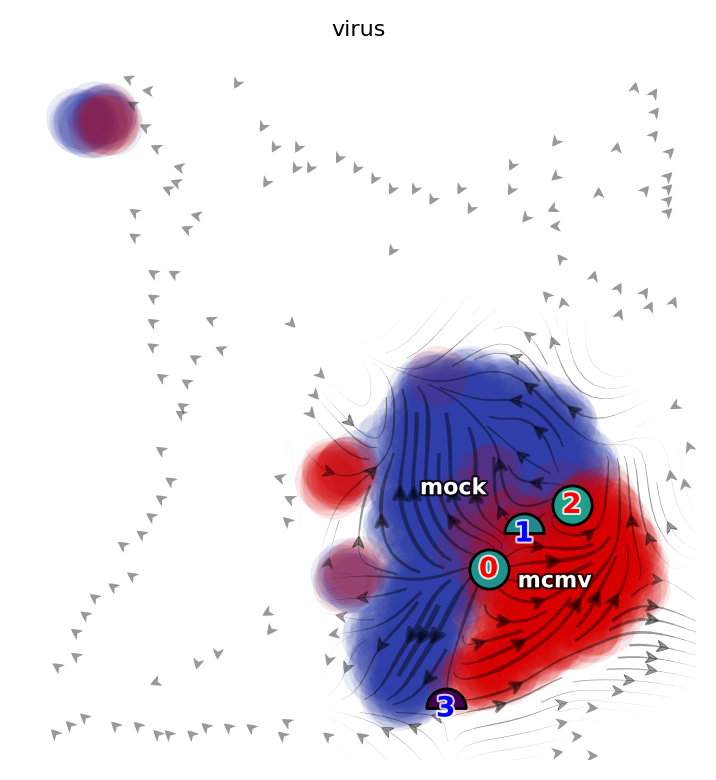

In [11]:
dyn.pl.topography(adata_MCMV, color=['virus'], basis='umap', terms=('streamline', 'fixed_points', 'trajectory'), init_state = np.array([10, 0]))


The above velocity estimation results are kind messy. Next, let us try velocity estimation based on scSLAM-seq data. 

Note that we use total RNA (labelled new RNA + unlabeled old RNA) as **spliced** while the new RNA as **unspliced**

In [12]:
tot_RNA = pd.read_csv('https://www.dropbox.com/s/skgesrran9d48oy/emat_tot.txt?dl=1', index_col=0, delimiter='\s')
new_RNA = pd.read_csv('https://www.dropbox.com/s/kz0xj8hw4tbab9r/smat_new.txt?dl=1', index_col=0, delimiter='\s')

from anndata import AnnData
adata_sc_slamseq_MCMV = AnnData(tot_RNA.values.T,
    layers=dict(
        unspliced=new_RNA.values.T,
        spliced = tot_RNA.values.T)) 
adata_sc_slamseq_MCMV

# again, let annotate cells by virus infection
batch = list()

for cell in tot_RNA.columns.values:
    regex = re.compile('mock')
    result = regex.search(cell)
    if result is not None:
        label = 'mock'
    else:
        label = 'mcmv'
    batch.append(label)
    
# add it to the vlm object
adata_sc_slamseq_MCMV.obs['virus'] = np.array(batch)
adata_sc_slamseq_MCMV

/Users/xqiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/xqiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


AnnData object with n_obs × n_vars = 87 × 583
    obs: 'virus'
    layers: 'unspliced', 'spliced'

In [13]:
dyn.pp.recipe_monocle(adata_sc_slamseq_MCMV, n_top_genes=583, normalized=True, fg_kwargs={'shared_count': 0})
adata_sc_slamseq_MCMV

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/preprocessing/preprocess.py:1364: UserWarning: only 419 genes passed basic filtering, but you requested 583 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}
  warnings.warn(f'only {pass_basic_filter_num} genes passed basic filtering, but you requested {n_top_genes} '
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/preprocessing/preprocess.py:1441: UserWarning: Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diag

AnnData object with n_obs × n_vars = 87 × 583
    obs: 'virus', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr'
    var: 'pass_basic_filter', 'use_for_pca', 'ntr'
    uns: 'pp_norm_method', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection'
    obsm: 'X_pca', 'X'
    layers: 'unspliced', 'spliced', 'X_unspliced', 'X_spliced'

In [14]:
adata_sc_slamseq_MCMV.layers['X_unspliced'], adata_sc_slamseq_MCMV.layers['X_spliced'] = adata_sc_slamseq_MCMV.layers['unspliced'], adata_sc_slamseq_MCMV.layers['spliced']

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
estimating gamma: 100%|██████████| 583/583 [00:00<00:00, 984.67it/s] 
/Users/xqiu/anaconda3/lib/python3.6/site-packages/dynamo_release-0.95.0-py3.6.egg/dynamo/tools/utils.py:738: RuntimeWarning: divide by zero encountered in true_divide
  adata.var.loc[valid_ind, kin_param_pre + "half_life"] = None if gamma is None else np.log(2) / gamma


<Figure size 600x400 with 0 Axes>

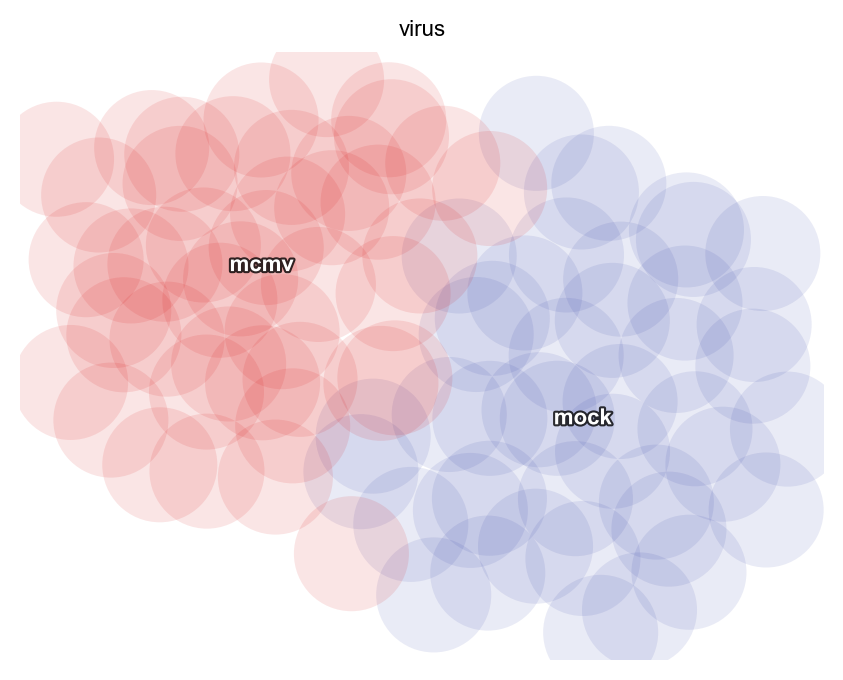

In [15]:
dyn.tl.dynamics(adata_sc_slamseq_MCMV, model='deterministic') 
dyn.tl.reduceDimension(adata_sc_slamseq_MCMV)

dyn.pl.umap(adata_sc_slamseq_MCMV, color='virus')

/Users/xqiu/anaconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
calculating transition matrix via pearson kernel with sqrt transform.: 100%|██████████| 87/87 [00:00<00:00, 1663.48it/s]
projecting velocity vector to low dimensional embedding...: 100%|██████████| 87/87 [00:00<00:00, 658.25it/s]


<Figure size 600x400 with 0 Axes>

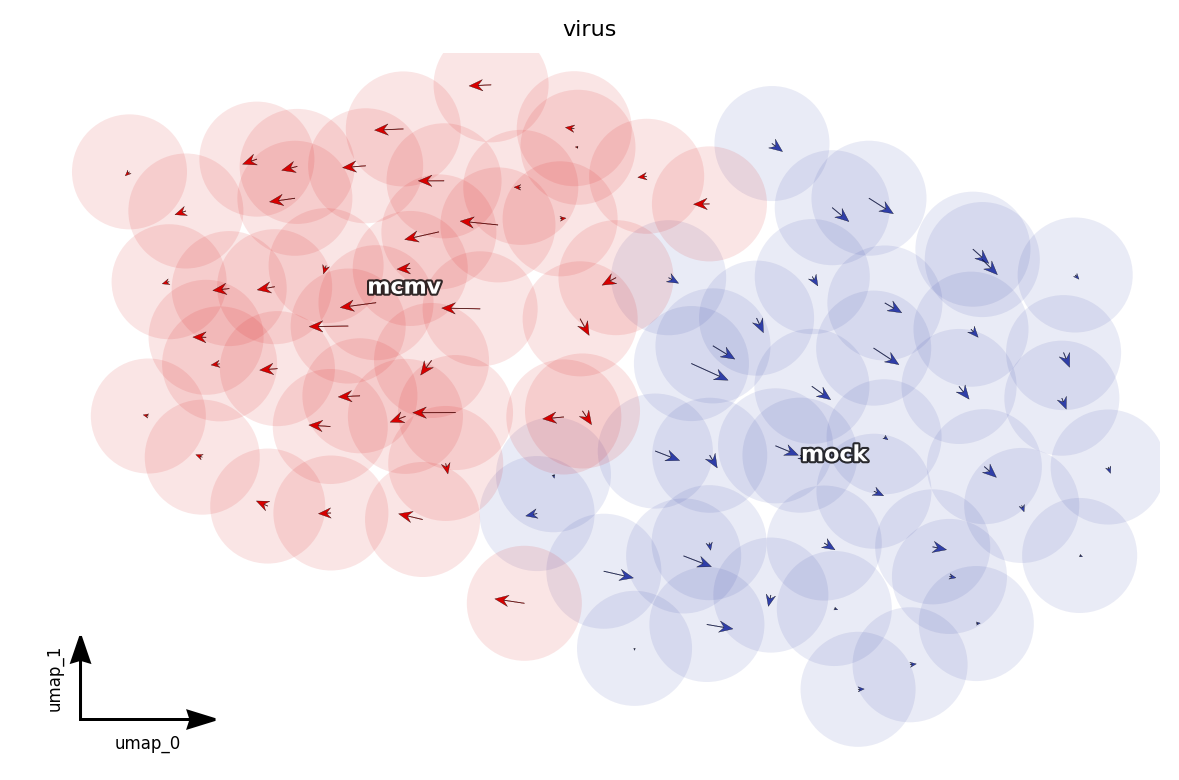

In [16]:
dyn.pl.cell_wise_vectors(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', quiver_size=2, show_legend='on data') # ['GRIA3', 'LINC00982', 'AFF2']


<Figure size 600x400 with 0 Axes>

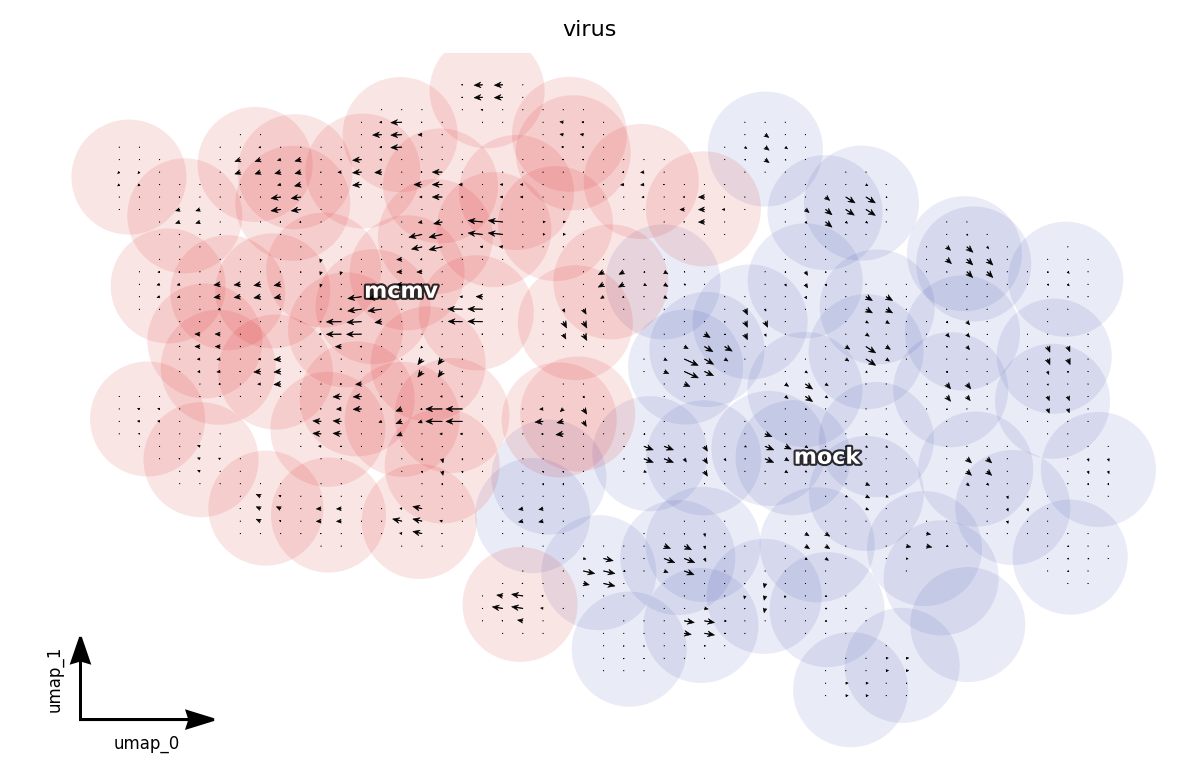

In [17]:
dyn.pl.grid_vectors(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', method='gaussian') # ['GRIA3', 'LINC00982', 'AFF2']


<Figure size 600x400 with 0 Axes>

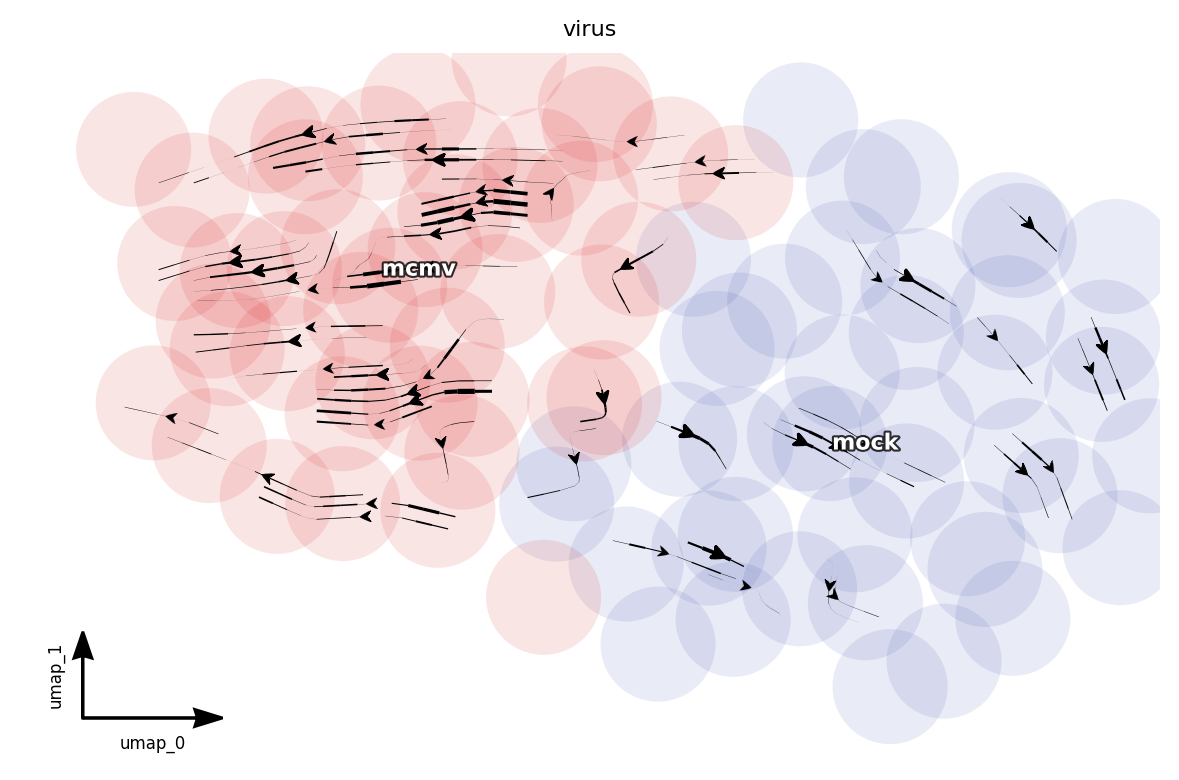

In [18]:
dyn.pl.streamline_plot(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', method='gaussian') # ['GRIA3', 'LINC00982', 'AFF2']


In [19]:
dyn.vf.VectorField(adata_sc_slamseq_MCMV, basis='umap')


<Figure size 600x400 with 0 Axes>

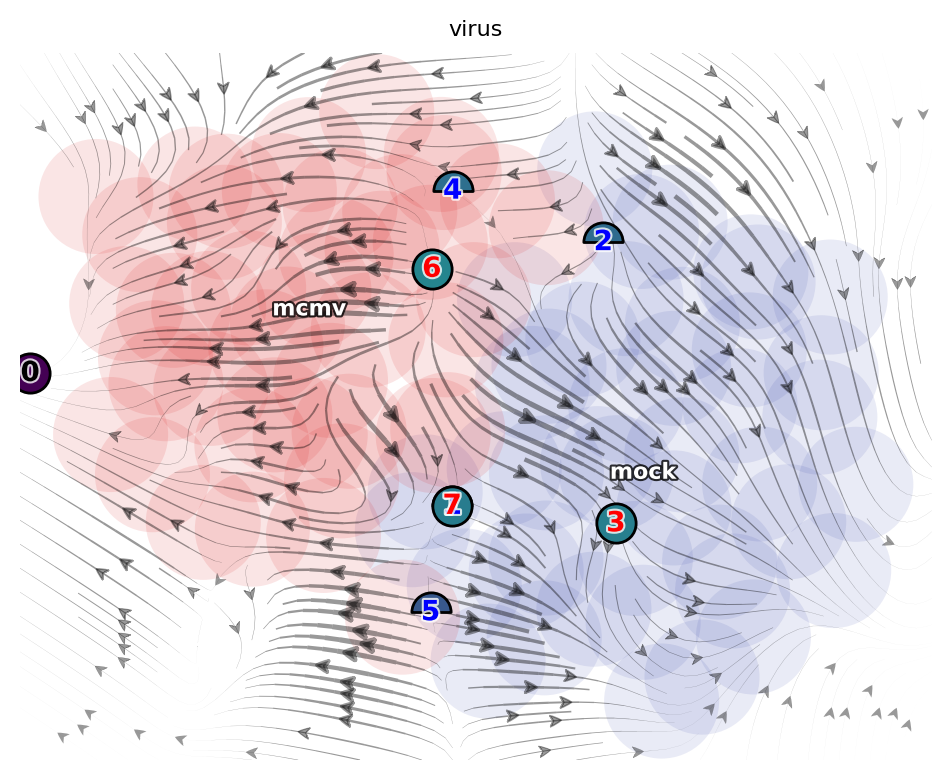

In [20]:
dyn.pl.topography(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', terms=('streamline', 'fixed_points', 'trajectory'))


<Figure size 600x400 with 0 Axes>

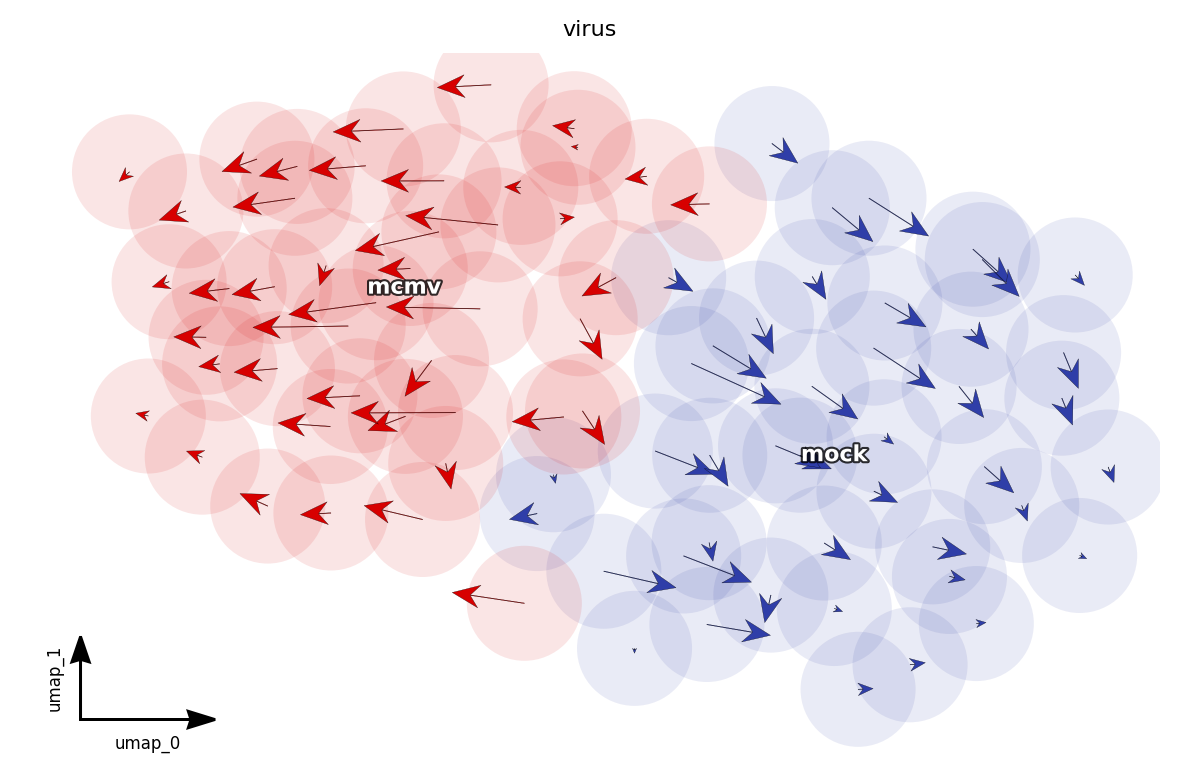

In [21]:
dyn.pl.cell_wise_vectors(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', quiver_size=4, quiver_length=5, show_legend='on data') # ['GRIA3', 'LINC00982', 'AFF2']


<Figure size 600x400 with 0 Axes>

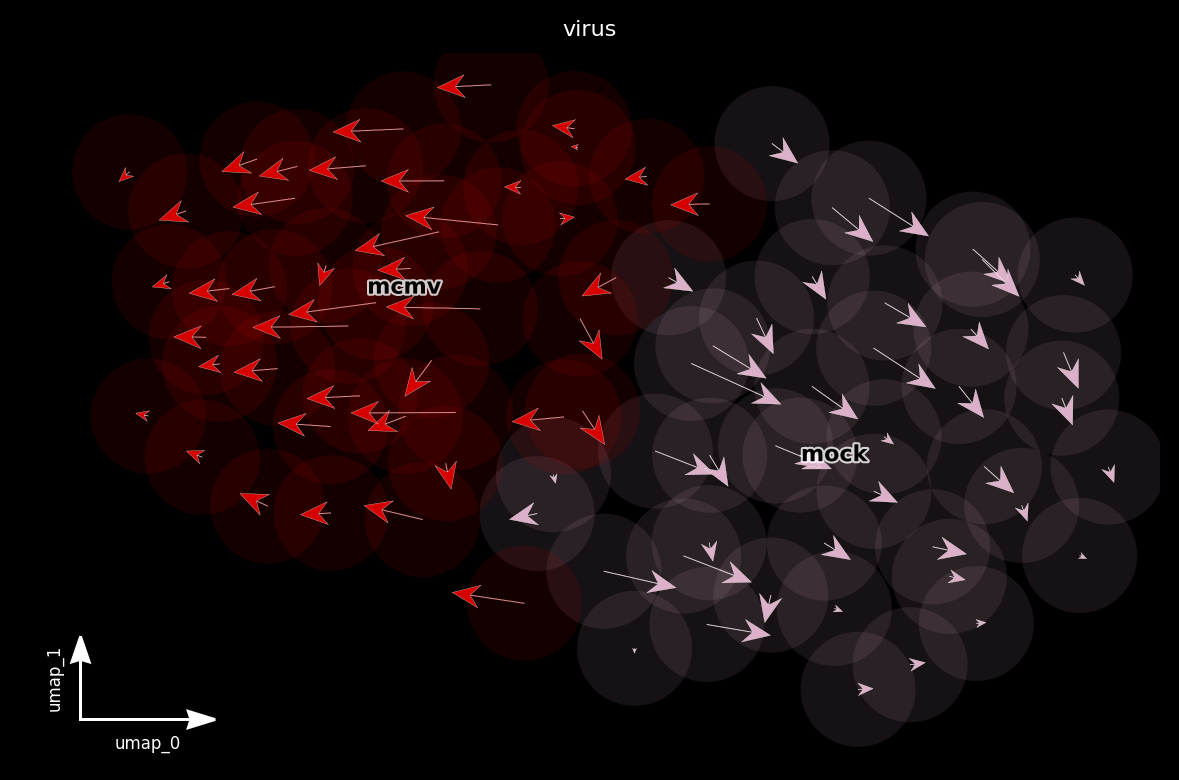

In [22]:
dyn.pl.cell_wise_vectors(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', 
                          quiver_size=4, quiver_length=5, show_legend='on data', background='black') # ['GRIA3', 'LINC00982', 'AFF2']


<Figure size 600x400 with 0 Axes>

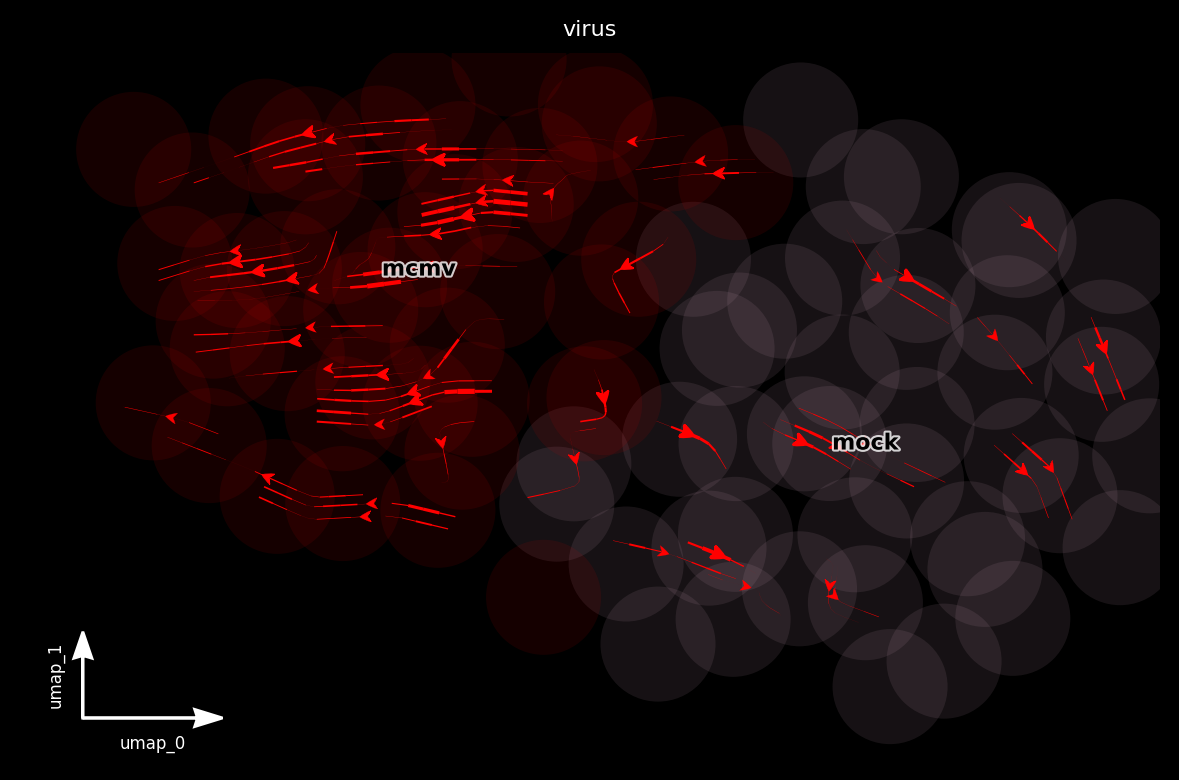

In [23]:
dyn.pl.streamline_plot(adata_sc_slamseq_MCMV, color=['virus'], basis='umap', show_legend='on data', background='black') # ['GRIA3', 'LINC00982', 'AFF2']


the velocity estimation here is much more apparent and consistent. let us save the result 